In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [3]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")


    def gradient_descent(self):
            for i in range(1, self.max_iterations + 1):
                Y_predict = self.predict(self.X).flatten()

                soft_term = self.soft_threshold(self.W, self.l1_penalty)
                dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m
                new_W = self.W - self.step_size * dW

                if np.mean(np.abs(new_W - self.W)) < self.tolerance:
                    break

                self.J.append((np.mean(np.abs(new_W - self.W)),))
                self.W = new_W
                self.iterations = i


    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            if r_norm < tol_prim and s_norm < tol_dual:
               break

        self.W = self.W.reshape(1, -1)


    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        print(f"Total rows used: {total_rows_used}")
        print(f"Rows per agent: {rows_per_agent}")

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))
            
            # Fusion center aggregates information from agents
            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            # Fusion center updates z based on aggregated information
            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            # Distribute updated information to agents
            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)
                
            global_u = np.mean(u, axis=0)    

            r_norm = np.linalg.norm(global_W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)  


In [3]:
def prediction_plot(Y_test, Y_pred, title):
    plt.scatter(Y_test, Y_pred, color='brown')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

In [5]:
df = pd.read_excel("Concrete_Data.xls")

In [6]:
df.columns = ['cement', 'slag', 'ash', 'water', 'superplasticizer', 'coarse', 'fine', 'age', 'strength']

In [7]:
df = df.sample(frac=1).reset_index(drop=True)

In [8]:
df.head()

,cement,slag,ash,water,superplasticizer,coarse,fine,age,strength
0,491.0,26.0,123.0,201.0,3.93,822.0,699.00,28,57.915984
1,362.6,189.0,0.0,164.9,11.60,944.7,755.80,28,71.298713
2,376.0,0.0,0.0,214.6,0.00,1003.5,762.36,100,43.057776
3,337.9,189.0,0.0,174.9,9.50,944.7,755.80,3,24.097186
4,397.0,0.0,0.0,185.7,0.00,1040.6,734.30,28,33.082437


In [9]:
df.shape

(1030, 9)

In [9]:
df.isna().sum()

cement              0
slag                0
ash                 0
water               0
superplasticizer    0
coarse              0
fine                0
age                 0
strength            0
dtype: int64

In [10]:
df.duplicated().sum()

25

In [11]:
df.drop_duplicates(inplace=True)

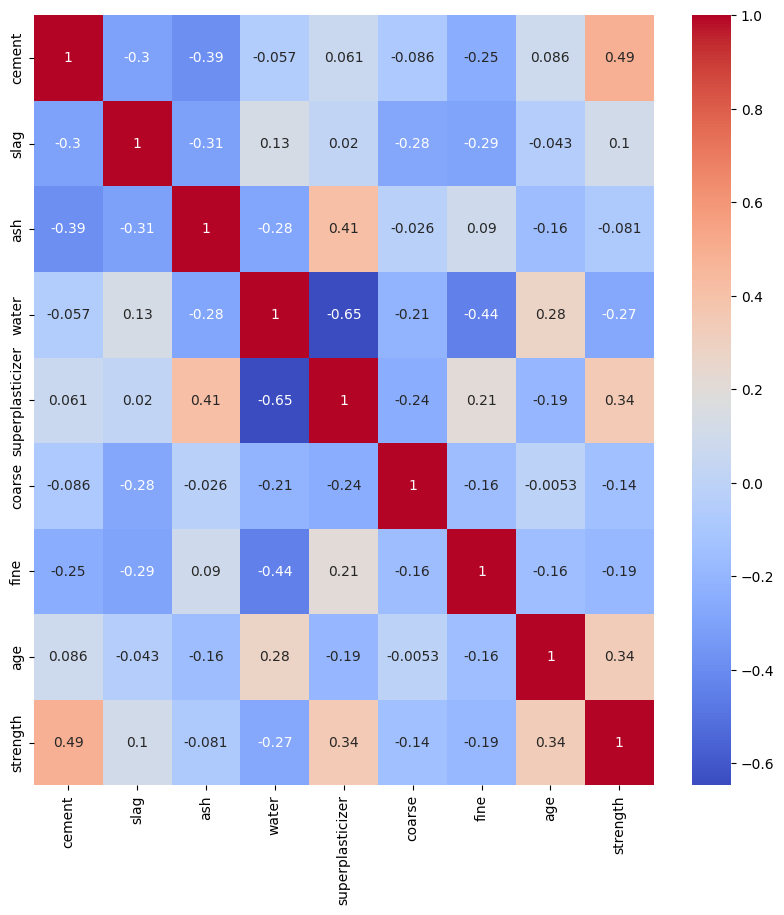

In [12]:
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [13]:
#labels
Y = df['strength'].values
X = df.drop('strength', axis=1).values

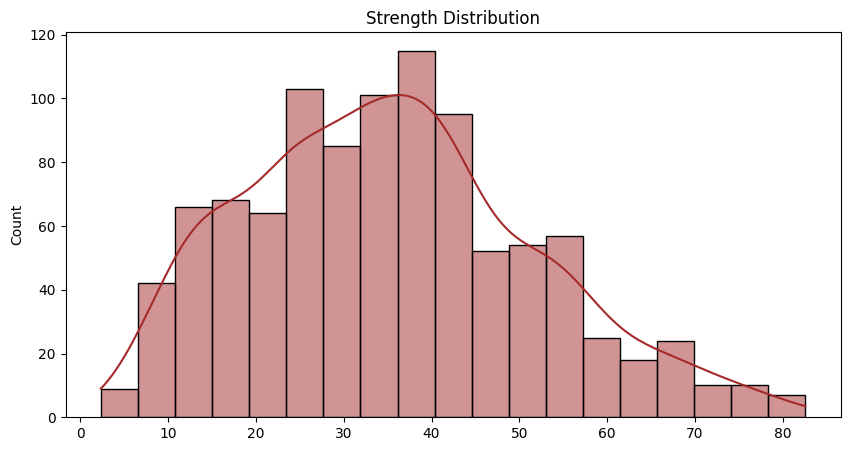

In [14]:
#labels distribution
plt.figure(figsize=(10, 5))
sns.histplot(Y, kde=True, color='brown')
plt.title('Strength Distribution')
plt.show()

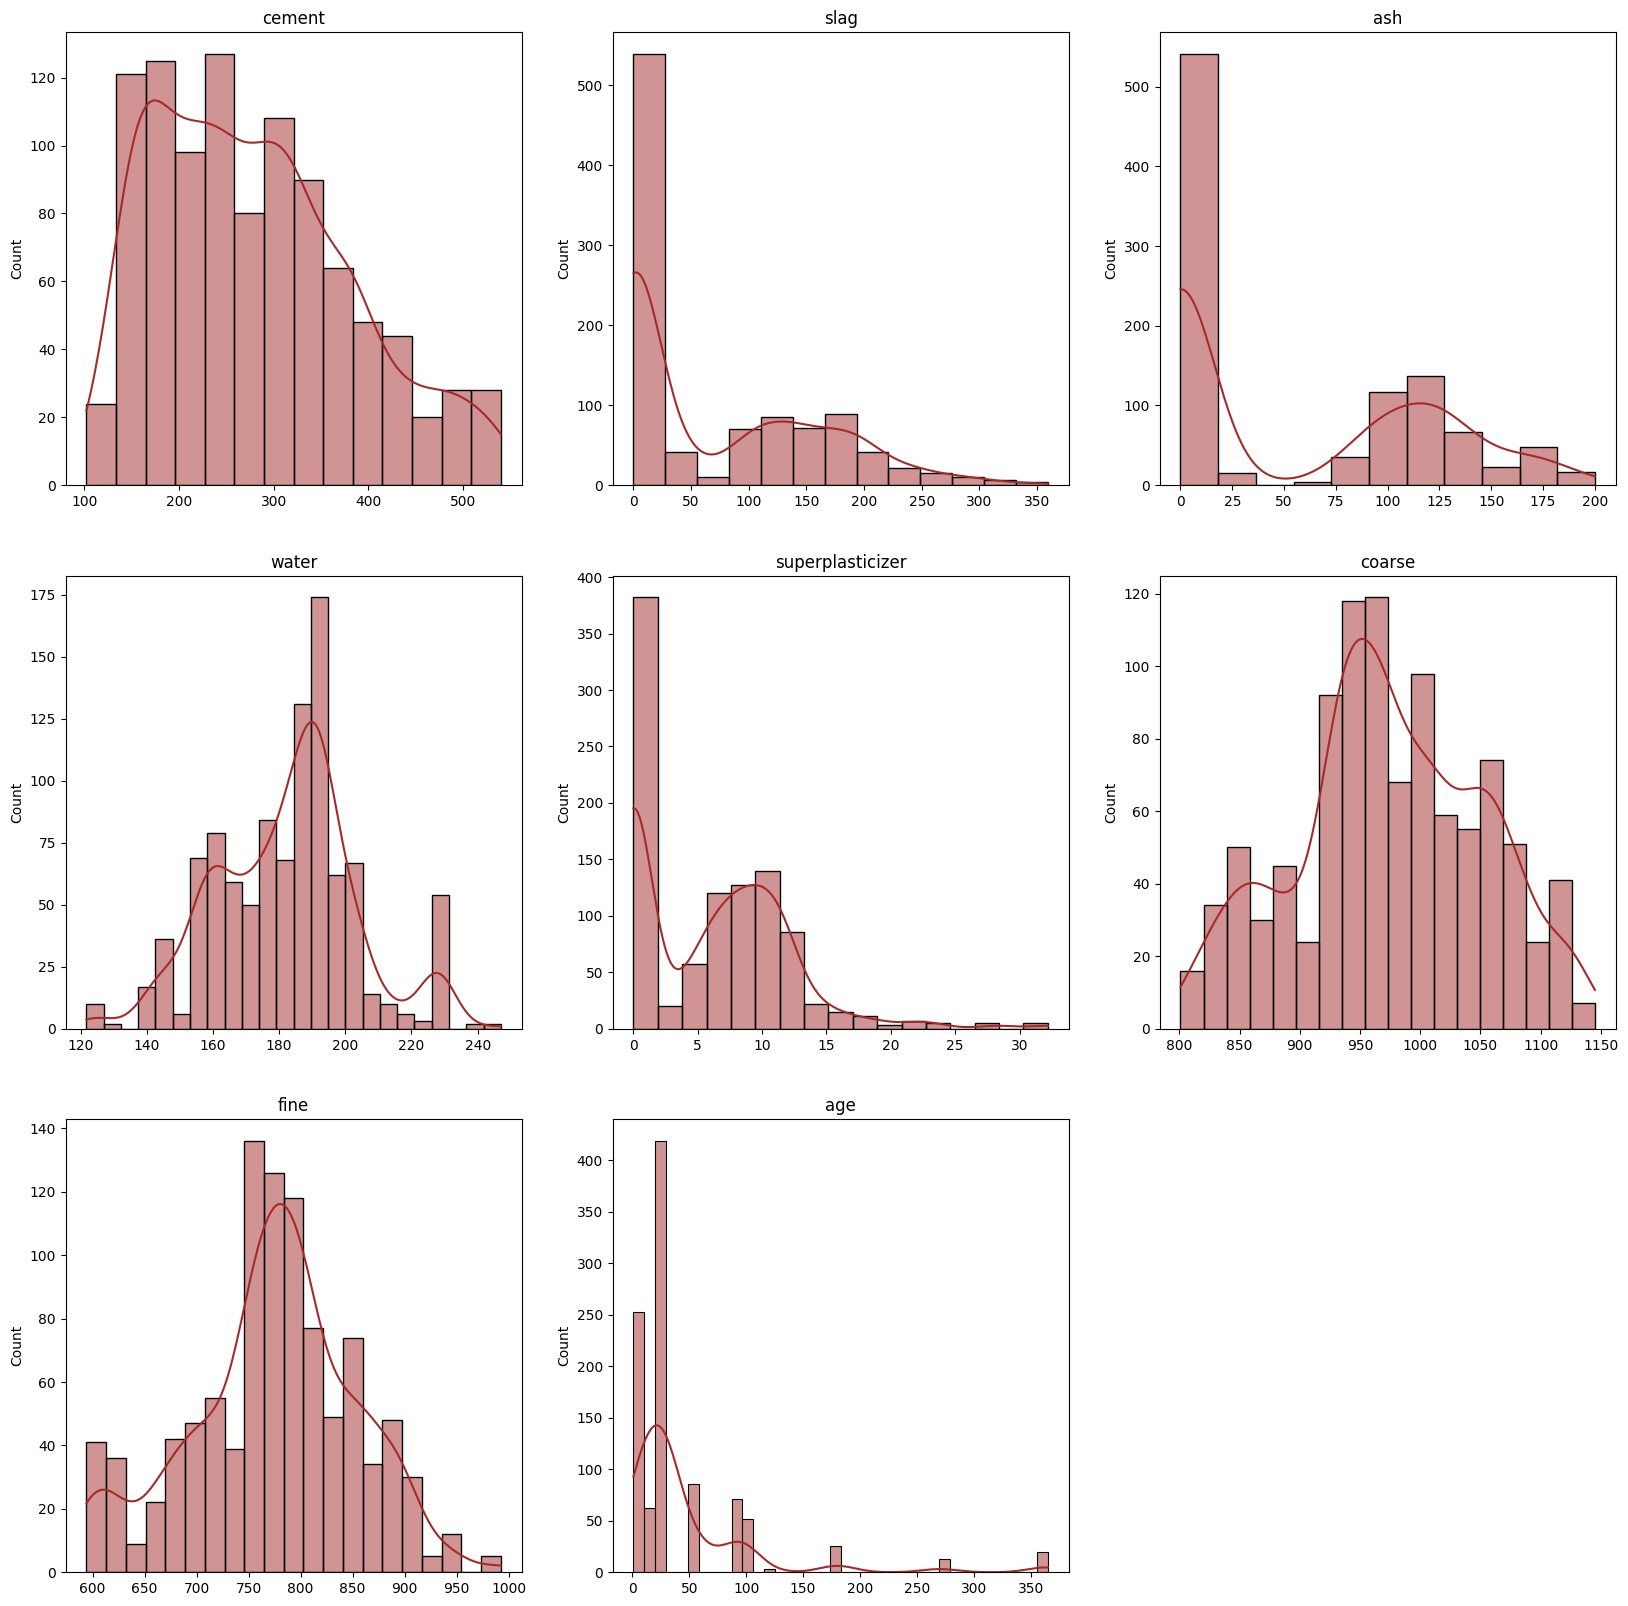

In [15]:
#features distribution
plt.figure(figsize=(20, 20))
for i in range(8):
    plt.subplot(3, 3, i + 1)
    sns.histplot(X[:, i], kde=True, color='brown')
    plt.title(df.columns[i])
plt.show()

In [15]:
#splitting the data
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [16]:
#scaling the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [17]:
#lasso parameters
step_size = 0.01
max_iterations = 100000
l1_penalty = 1
tolerance = 1e-3
agents = 5

In [18]:
start_time = time.time()
lasso = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso.fit(X_train, Y_train, "gd")
Y_pred = lasso.predict(X_test)
end_time = time.time()
print(f"Time taken for GD: {end_time - start_time} seconds")
iteration = lasso.iterations
print(f"Number of iterations: {iteration}")

Time taken for GD: 0.29758572578430176 seconds
Number of iterations: 4616


In [19]:
#metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 120.77903587140402
R2 Score: 0.5535698339655759
Mean Absolute Error: 8.793752602447908


In [20]:
prediction_plot(Y_test, Y_pred, "Lasso Regression (GD)")

NameError: name 'prediction_plot' is not defined

In [21]:
def loss_plot(J, title):
    plt.plot(J, color='brown')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

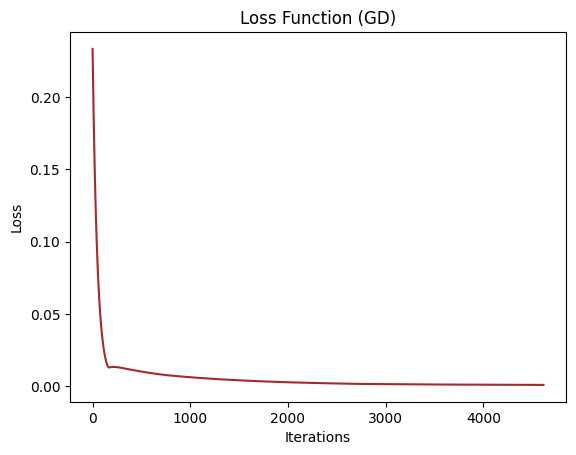

In [22]:
loss_plot(lasso.J, "Loss Function (GD)")

In [23]:
#ADMM
start_time = time.time()
lasso = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso.fit(X_train, Y_train, "admm")
Y_pred = lasso.predict(X_test)
end_time = time.time()
print(f"Time taken for ADMM: {end_time - start_time} seconds")
iteration = lasso.iterations
print(f"Number of iterations: {iteration}")


Time taken for ADMM: 7.814045190811157 seconds
Number of iterations: 100000


In [24]:
#metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 112.76301211708426
R2 Score: 0.5831991052191324
Mean Absolute Error: 8.641596662588025


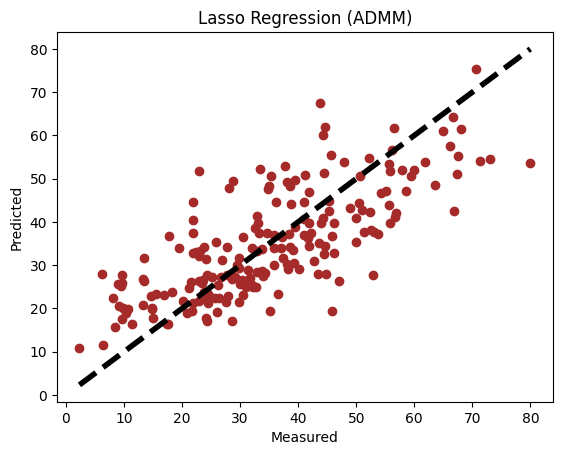

In [26]:
prediction_plot(Y_test, Y_pred, "Lasso Regression (ADMM)")

In [25]:
def loss_plot_admm(J, title):
    
    r_loss = [row[0] for row in J]  
    s_loss = [row[1] for row in J]  

    plt.plot(r_loss, label='primary residual', color='purple')
    plt.plot(s_loss, label='dual residual', color='green')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

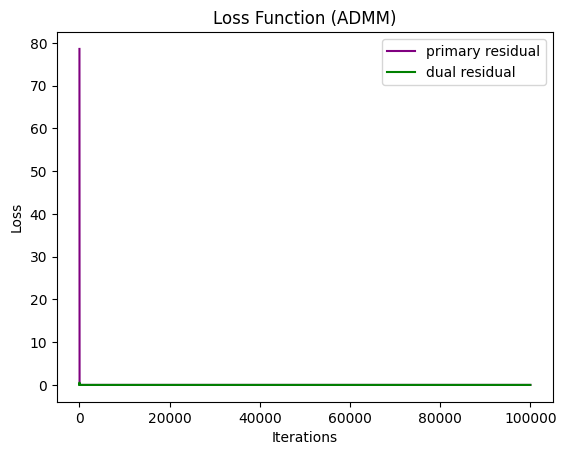

In [26]:
loss_plot_admm(lasso.J, "Loss Function (ADMM)")

In [29]:
#Distributed ADMM
start_time = time.time()
lasso = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso.fit(X_train, Y_train, "distributed_admm", agents)
Y_pred = lasso.predict(X_test)
end_time = time.time()
print(f"Time taken for Distributed ADMM: {end_time - start_time} seconds")
iteration = lasso.iterations
print(f"Number of iterations: {iteration}")

Total rows used: 800
Rows per agent: 160
Time taken for Distributed ADMM: 0.004000663757324219 seconds
Number of iterations: 3


In [30]:
#metrics
mse = mean_squared_error(Y_test, Y_pred)
r2 = r2_score(Y_test, Y_pred)
mae = mean_absolute_error(Y_test, Y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R2 Score: {r2}")
print(f"Mean Absolute Error: {mae}")


Mean Squared Error: 107.03048715955839
R2 Score: 0.564101270754019
Mean Absolute Error: 8.24378921225152


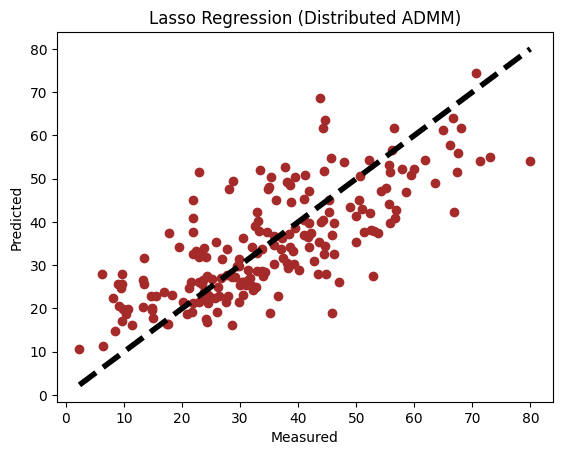

In [31]:
prediction_plot(Y_test, Y_pred, "Lasso Regression (Distributed ADMM)")

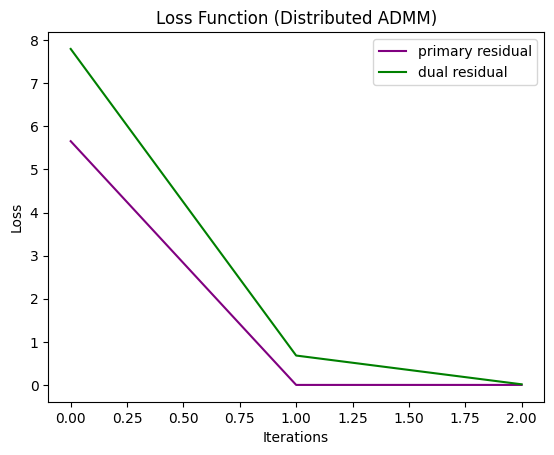

In [32]:
loss_plot_admm(lasso.J, "Loss Function (Distributed ADMM)")